<h2 style="color:blue" align="center">3 Blocks VGG-16 on CIFAR</h2>

#### Import the necessary libraries

In [146]:
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 

from tensorflow import keras  
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D 
from keras.callbacks import Callback, CSVLogger
from keras.utils import to_categorical 
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

#### Reserve memory for the execution

In [147]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


#### Load and split the dataset into training and testing set

CIFAR 10

In [148]:
(X_train,y_train),(X_test,y_test) = keras.datasets.cifar10.load_data()

CIFAR 100

In [149]:
#(X_train,y_train),(X_test,y_test) = keras.datasets.cifar100.load_data()

#### Normalize the input dataset

In [150]:
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

#### One hot encoding

In [151]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### Define VGG model with 3 layers

In [152]:
python_random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)
opti_name = ''

def get_model(): 
    model = Sequential([ 
        # VGG Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # VGG Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # VGG Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Dense layer
        Flatten(), 
        Dense(128, activation = 'relu'), 
        Dense(64, activation = 'relu'), 
        # CIFAR 10
        Dense(10, activation = 'softmax')
        # CIFAR 100
        #Dense(100, activation = 'softmax')
    ]) 
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.001)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax' 
    
    # Nadam
    #opti = keras.optimizers.Nadam(learning_rate=0.001) 
    #opti_name = 'Nadam'  
    
    model.compile(
        optimizer = opti,
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [153]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):  
    def on_epoch_end(self, epoch, logs={}): 
        global generic_best
        accuracy = round(logs.get('accuracy'), 4) 
        
        if epoch == 0:
            generic_best = accuracy     
        
        if epoch > 0 and accuracy < generic_best :
            generic_best = accuracy

For HM based optimizer model

In [154]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0    
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  

    def on_epoch_end(self, epoch, logs={}): 
         # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(len(current_weights)):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i])
            tensor2 = tf.convert_to_tensor(current_weights[i])
            current_weights[i] = self.call_hm(tensor1, tensor2, epoch)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights 
        
        #Stopping criteria
        #if(round(logs.get('accuracy'), 4) < generic_best):  
            #self.model.stop_training = True
        
    def apply_hm(self, v1, v2, epoch):  
        r = 1
        if v1==0 or v2==0:
            return v2
        elif v1 > v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1) * r 
            v2 = v2 - diff
            return v2  
        elif v1 < v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1) * r 
            v2 = v2 + diff
            return v2   
        else:
            return v2   

In [155]:
len(model.layers)

13

#### Training

Generic opimizer model

In [156]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 10
batch_size = 256

To record loss and accuracy in CSV file

In [157]:
generic_file = '6.CIFAR (VGG)'+opti_name+' optimizer.csv'
hm_file = '6.CIFAR (VGG)'+opti_name+' HM-based optimizer.csv' 
logger_generic_model = CSVLogger(generic_file, append = False, separator=',')
logger_hm_model = CSVLogger(hm_file, append = False, separator=',')

Generic opimizer model

In [158]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time() 
model_wihtout_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_generic = round(et - st, 4)
print('Execution time:', elapsed_training_time_generic, 'seconds') 

Epoch 1/10
196/196 [==============================] - 2s 7ms/step - loss: 1.6852 - accuracy: 0.3764
Epoch 2/10
196/196 [==============================] - 1s 7ms/step - loss: 1.2351 - accuracy: 0.5528
Epoch 3/10
196/196 [==============================] - 1s 7ms/step - loss: 1.0045 - accuracy: 0.6431
Epoch 4/10
196/196 [==============================] - 1s 7ms/step - loss: 0.8541 - accuracy: 0.7009
Epoch 5/10
196/196 [==============================] - 1s 7ms/step - loss: 0.7333 - accuracy: 0.7421
Epoch 6/10
196/196 [==============================] - 1s 7ms/step - loss: 0.6481 - accuracy: 0.7728
Epoch 7/10
196/196 [==============================] - 2s 8ms/step - loss: 0.5624 - accuracy: 0.8037
Epoch 8/10
196/196 [==============================] - 1s 7ms/step - loss: 0.4922 - accuracy: 0.8278
Epoch 9/10
196/196 [==============================] - 1s 7ms/step - loss: 0.4171 - accuracy: 0.8533
Epoch 10/10
196/196 [==============================] - 1s 7ms/step - loss: 0.3569 - accuracy: 0.8752

HM based optimizer model

In [159]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_hm = round(et - st, 4)
print('Execution time:', elapsed_training_time_hm, 'seconds')

Epoch 1/10
196/196 [==============================] - 2s 8ms/step - loss: 1.6965 - accuracy: 0.3740
Epoch 2/10
196/196 [==============================] - 1s 8ms/step - loss: 1.3900 - accuracy: 0.5020
Epoch 3/10
196/196 [==============================] - 2s 8ms/step - loss: 1.0778 - accuracy: 0.6138
Epoch 4/10
196/196 [==============================] - 1s 7ms/step - loss: 0.8823 - accuracy: 0.6890
Epoch 5/10
196/196 [==============================] - 1s 7ms/step - loss: 0.7524 - accuracy: 0.7362
Epoch 6/10
196/196 [==============================] - 2s 8ms/step - loss: 0.6387 - accuracy: 0.7747
Epoch 7/10
196/196 [==============================] - 1s 8ms/step - loss: 0.5353 - accuracy: 0.8115
Epoch 8/10
196/196 [==============================] - 1s 7ms/step - loss: 0.4483 - accuracy: 0.8436
Epoch 9/10
196/196 [==============================] - 1s 7ms/step - loss: 0.3781 - accuracy: 0.8686
Epoch 10/10
196/196 [==============================] - 1s 7ms/step - loss: 0.3063 - accuracy: 0.8915

Model summary

In [160]:
model_hm.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_186 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_187 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_188 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_189 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                

#### Generic optimizer vs HM-based optimizer

In [161]:
df1 = pd.read_csv(generic_file)
df2 = pd.read_csv(hm_file)

Loss

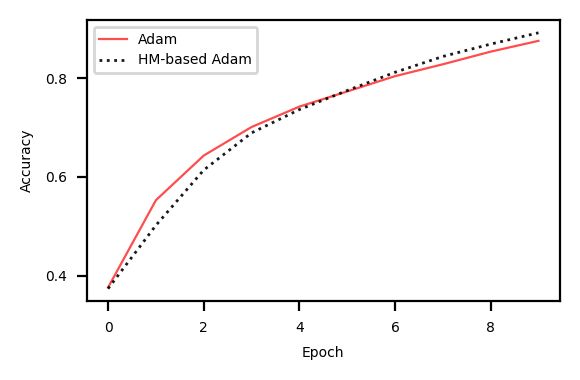

In [162]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['accuracy'] 
y2 = df2['accuracy']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Accuracy' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show() 

Accuracy

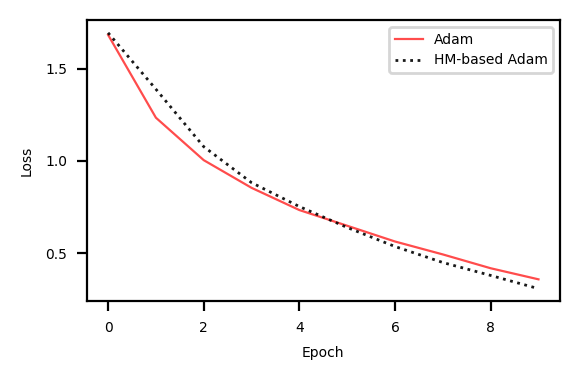

In [163]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']   
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()  

###### Testing the model

Generic opimizer model

In [164]:
model_wihtout_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7300 - accuracy: 0.7665


[0.7299944162368774, 0.7664999961853027]

HM based optimizer model

In [165]:
model_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.9308 - accuracy: 0.7438


[0.9308401346206665, 0.7437999844551086]

#### Release the GPU memory